In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from sqlalchemy import create_engine
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
username = "privateuser"
password = "***********"
port = 7777

engine = create_engine('mysql+mysqldb://%s:%s@localhost:%i/Shutterfly'%(username, password, port))

### Table Summary
__Observation__
* event1 has 83% of rows missing. This cannot be the variable we are trying to predict.
* prodcat2 has 0.7% missing values.
* No other column has missing value.
* Numeric variables: revenue
* Categorical variables: category, event1, prodcat1, prodcat2

In [3]:
def examine_feature(col_name, tab_name):
    return """
    SELECT 
        "%s" AS col
        ,COUNT(%s) AS non_null
        ,ROUND(100 * COUNT(%s) / COUNT(*), 2) AS pct_non_null
        ,COUNT(DISTINCT %s) AS cardinality
        ,ROUND(100 * COUNT(DISTINCT %s) / COUNT(*), 2) AS sensitivity
    FROM %s
    """%(col_name, col_name, col_name, col_name, col_name, tab_name)

##### Online table

In [4]:
df_online = pd.read_csv("data/online.csv")
print("%i rows in df_online"%(len(df_online)))
df_online.describe()

954774 rows in df_online


,session,visitor,custno,category,event1,event2
count,9.547740e+05,954774.000000,954774.000000,954774.000000,164928.000000,954774.000000
mean,1.893075e+06,246963.121538,37011.541473,2.684933,4.501576,5.666678
std,1.086779e+06,145929.540403,21559.691539,0.571617,3.494639,2.368242
min,2.000000e+00,1.000000,6.000000,1.000000,1.000000,1.000000
25%,9.554362e+05,125528.250000,17985.000000,2.000000,NaN,4.000000
50%,1.903075e+06,252901.000000,38040.000000,3.000000,NaN,7.000000
75%,2.845886e+06,377563.000000,56516.000000,3.000000,NaN,7.000000
max,3.750761e+06,505850.000000,71427.000000,3.000000,11.000000,10.000000


In [83]:
print(min(df_online.dt))
print(max(df_online.dt))
df_online.head()

2016-01-01 00:00:08
2017-12-31 23:58:05


,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [5]:
sql = " UNION ALL ".join([examine_feature(col_name, 'Online') for col_name in df_online.columns.values])
pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)

,col,non_null,pct_non_null,cardinality,sensitivity
0,session,954774,100.00,850235,89.05
1,visitor,954774,100.00,259950,27.23
2,dt,954774,100.00,942579,98.72
3,custno,954774,100.00,57584,6.03
4,category,954774,100.00,3,0.00
5,event1,164928,17.27,10,0.00
6,event2,954774,100.00,10,0.00


##### Order Table

In [121]:
df_order = pd.read_csv("data/Order.csv")
print("%i rows in df_order"%(len(df_order)))
df_order.describe()

263278 rows in df_order


,custno,ordno,prodcat2,prodcat1,revenue
count,263278.000000,263278.000000,261455.000000,263278.000000,263278.000000
mean,19244.733855,64173.395620,37.384330,2.920924,74.939302
std,19414.103037,43064.595961,44.639098,1.696565,43.277175
min,1.000000,1.000000,2.000000,1.000000,0.000000
25%,3438.000000,26505.000000,NaN,2.000000,37.430000
50%,11389.500000,59040.500000,NaN,2.000000,74.930000
75%,31459.000000,98340.750000,NaN,4.000000,112.280000
max,71427.000000,154405.000000,263.000000,7.000000,150.000000


In [84]:
print(min(df_order.orderdate))
print(max(df_order.orderdate))
df_order.head()

2016-01-01 05:05:14
2019-01-02 23:54:58


,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


In [7]:
sql = " UNION ALL ".join([examine_feature(col_name, 'Purchase') for col_name in df_order.columns.values])
pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)

,col,non_null,pct_non_null,cardinality,sensitivity
0,custno,263278,100.00,70264,26.69
1,ordno,263278,100.00,149717,56.87
2,orderdate,263278,100.00,149482,56.78
3,prodcat2,261455,99.31,251,0.10
4,prodcat1,263278,100.00,6,0.00
5,revenue,263278,100.00,15001,5.70


### Distirbution
__Observation__:
* Revenue is approximately uniformly distirbuted.
* Categorical variables have highly unbalanced distirbution.
* Product category 2 in prodcat1 is the most popular catgory.
* Product category 3 in prodcat2 is the most popular catgory.

##### Revenue: Uniform Distribution

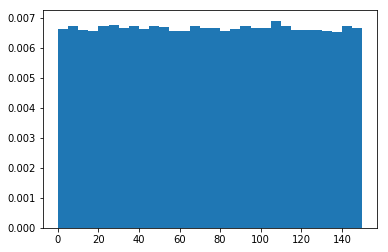

In [10]:
plt.hist(df_order.revenue, density=True, bins=30)
plt.show()

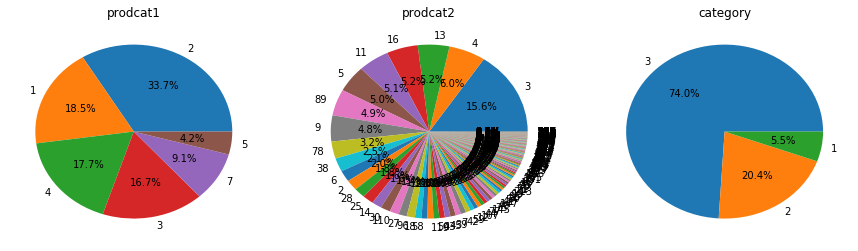

In [150]:
plt.figure(figsize=(15, 4))

ax1 = plt.subplot(1, 3, 1)

value_counts = df_order.prodcat1.value_counts()
values = value_counts.values
labels = value_counts.index
_ = ax1.pie(x = values, 
            labels = labels,
            autopct='%1.1f%%', 
            labeldistance = 1.1)
ax1.set_title('prodcat1')

ax2 = plt.subplot(1, 3, 2)

value_counts = df_order.prodcat2.value_counts()
values = value_counts.values
labels = list(map(int, value_counts.index))
_ = ax2.pie(x = values, 
            labels = labels,
            autopct='%1.1f%%',
            labeldistance = 1.1)

ax2.set_title('prodcat2')

ax3 = plt.subplot(1, 3, 3)

value_counts = df_online.category.value_counts()
values = value_counts.values
labels = list(map(int, value_counts.index))
_ = ax3.pie(x = values, 
            labels = labels,
            autopct='%1.1f%%',
            labeldistance = 1.1)

ax3.set_title('category')

plt.show()

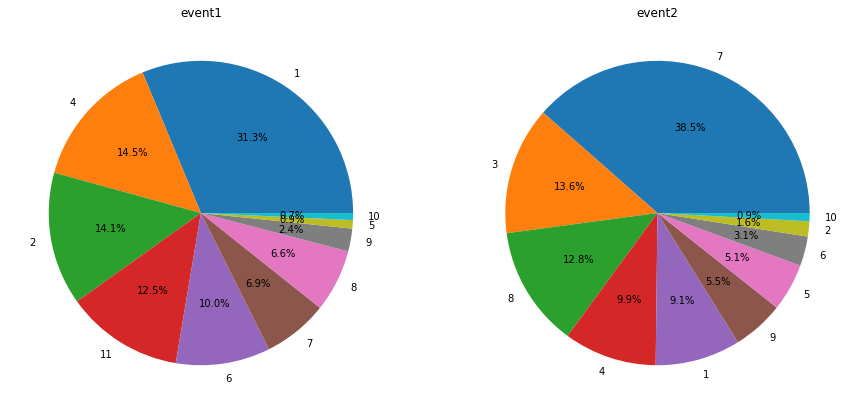

In [153]:
plt.figure(figsize=(15, 7))

ax1 = plt.subplot(1, 2, 1)

value_counts = df_online.event1.value_counts()
values = value_counts.values
labels = list(map(int, value_counts.index))
_ = ax1.pie(x = values, 
            labels = labels,
            autopct='%1.1f%%', 
            labeldistance = 1.1)
ax1.set_title('event1')

ax2 = plt.subplot(1, 2, 2)

value_counts = df_online.event2.value_counts()
values = value_counts.values
labels = list(map(int, value_counts.index))
_ = ax2.pie(x = values, 
            labels = labels,
            autopct='%1.1f%%',
            labeldistance = 1.1)

ax2.set_title('event2')

plt.show()

In [8]:
def kde(z, w, xv):
    return sum(np.exp(-0.5 * ((z - xv) / w) ** 2) / np.sqrt(2 * np.pi * w ** 2))

In [9]:
def density_estimate(y, w=0.03):
    df = pd.DataFrame(columns=["x", "y"])
    for x in np.linspace(min(y) - w, max(y) + w, 1000):
        df = df.append({"x": x, "y" : kde(x, w, y)}, ignore_index=True)
    return df

In [172]:
def plot_density(array, width):
    kde_prob = density_estimate(array, w=width)

    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.set_ylabel('kde')
    ax1.plot(kde_prob.x, kde_prob.y)

    ax2 = ax1.twinx()
    ax2.hist(array, alpha=0.4)

    plt.show()

### Seasonality of Revenue

In [110]:
sql = """
SELECT 
	LEFT(orderdate, 10) AS day
	,SUM(revenue) AS daily_revenue
	,COUNT(*) AS daily_order
FROM Purchase
GROUP BY day
ORDER BY day;
"""

In [111]:
df_order_agg = pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)
df_order_agg.day = [datetime.strptime(dt, "%Y-%m-%d") for dt in df_order_agg.day.values]
df_order_agg.set_index("day", inplace=True)

df_order_agg["rev_p_ord"] = df_order_agg.daily_revenue / df_order_agg.daily_order
df_order_agg.head()

,daily_revenue,daily_order,rev_p_ord
day,,,
2016-01-01,15811.66,207,76.384831
2016-01-02,18697.29,249,75.089518
2016-01-03,32291.25,449,71.918151
2016-01-04,27839.62,373,74.637051
2016-01-05,35685.33,471,75.765032


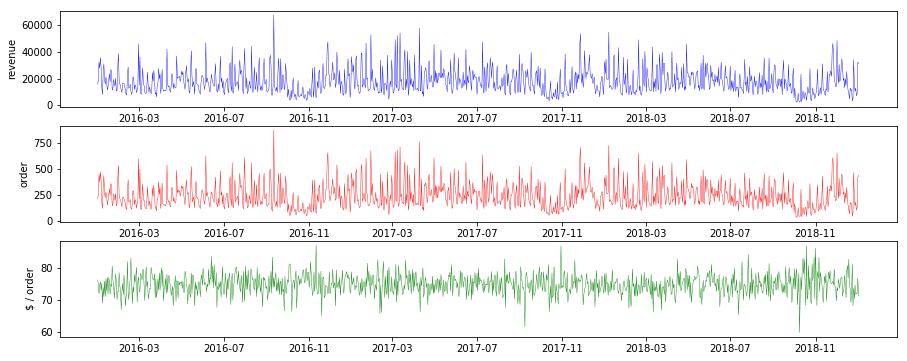

In [112]:
plt.figure(figsize=(15, 6))

ax1 = plt.subplot(3, 1, 1)
ax1.set_ylabel('revenue')
ax1.plot(df_order_agg.index, df_order_agg.daily_revenue, color='b', linewidth=0.4)

ax2 = plt.subplot(3, 1, 2)
ax2.set_ylabel('order')
ax2.plot(df_order_agg.index, df_order_agg.daily_order, color='r', linewidth=0.4)

ax3 = plt.subplot(3, 1, 3)
ax3.set_ylabel('$ / order')
ax3.plot(df_order_agg.index, df_order_agg.rev_p_ord, color='g', linewidth=0.4)

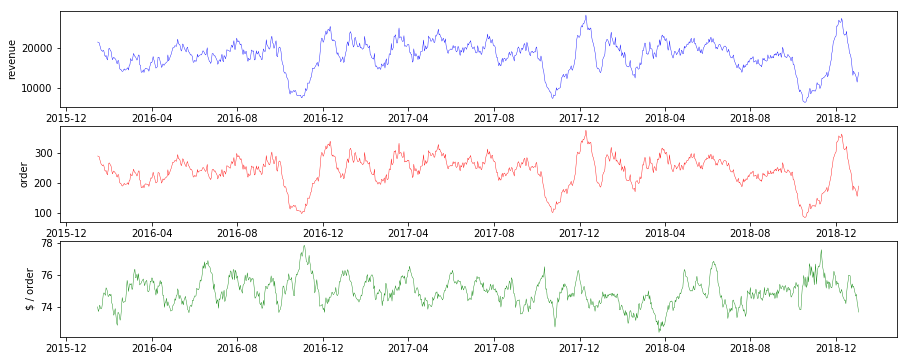

In [113]:
df_order_agg_ma = df_order_agg.rolling(15).mean()

plt.figure(figsize=(15, 6))

ax1 = plt.subplot(3, 1, 1)
ax1.set_ylabel('revenue')
ax1.plot(df_order_agg_ma.index, df_order_agg_ma.daily_revenue, color='b', linewidth=0.4)

ax2 = plt.subplot(3, 1, 2)
ax2.set_ylabel('order')
ax2.plot(df_order_agg_ma.index, df_order_agg_ma.daily_order, color='r', linewidth=0.4)

ax3 = plt.subplot(3, 1, 3)
ax3.set_ylabel('$ / order')
ax3.plot(df_order_agg_ma.index, df_order_agg_ma.rev_p_ord, color='g', linewidth=0.4)

In [118]:
df_order_agg_ma.describe()

,daily_revenue,daily_order,rev_p_ord
count,1084.000000,1084.000000,1084.000000
mean,17942.985990,239.373247,74.953640
std,3778.110381,50.547637,0.839950
min,6544.882667,85.666667,72.407752
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,28078.044000,375.600000,77.870749


In [116]:
df_order_agg.corr()

,daily_revenue,daily_order,rev_p_ord
daily_revenue,1.000000,0.997272,0.066501
daily_order,0.997272,1.000000,0.002493
rev_p_ord,0.066501,0.002493,1.000000


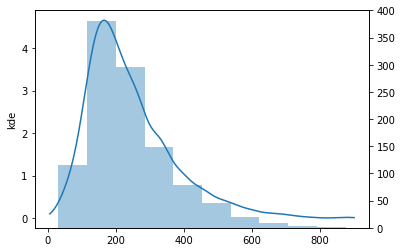

In [174]:
plot_density(df_order_agg.daily_order, width = 25)

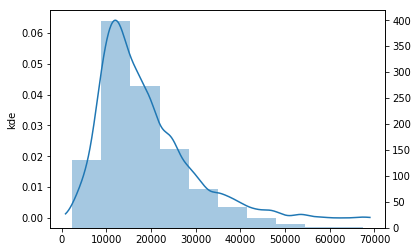

In [178]:
plot_density(df_order_agg.daily_revenue, width = 1500)

### Seasonality of Activity

In [89]:
sql = """
SELECT 
	LEFT(dt, 10) AS day
	,COUNT(DISTINCT visitor) AS daily_visitor
	,COUNT(DISTINCT session) AS daily_session
	,SUM(category=1) AS category_1
	,SUM(category=2) AS category_2
	,SUM(category=1) AS category_3
FROM Online
GROUP BY day
ORDER BY day;
"""

In [92]:
df_online_agg = pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)
df_online_agg.day = [datetime.strptime(dt, "%Y-%m-%d") for dt in df_online_agg.day.values]
df_online_agg.set_index("day", inplace=True)

df_online_agg.head()

,daily_visitor,daily_session,category_1,category_2,category_3
day,,,,,
2016-01-01,900,1011,72.0,171.0,72.0
2016-01-02,898,1005,68.0,135.0,68.0
2016-01-03,1409,1584,139.0,217.0,139.0
2016-01-04,1250,1377,69.0,151.0,69.0
2016-01-05,1373,1530,85.0,174.0,85.0


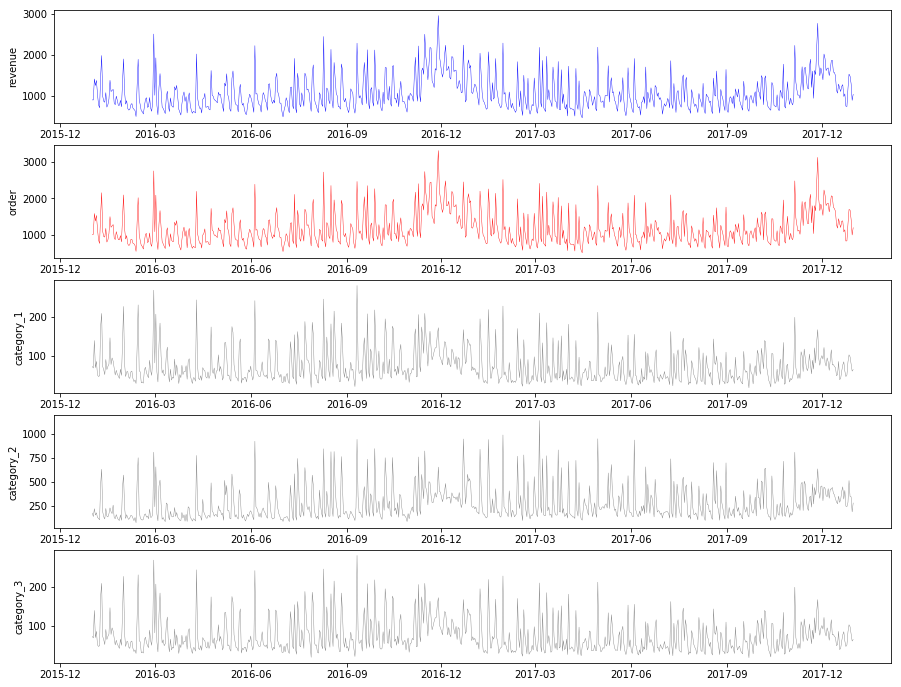

In [101]:
plt.figure(figsize=(15, 12))

ax1 = plt.subplot(5, 1, 1)
ax1.set_ylabel('revenue')
ax1.plot(df_online_agg.index, df_online_agg.daily_visitor, color='b', linewidth=0.4)

ax2 = plt.subplot(5, 1, 2)
ax2.set_ylabel('order')
ax2.plot(df_online_agg.index, df_online_agg.daily_session, color='r', linewidth=0.4)

ax3 = plt.subplot(5, 1, 3)
ax3.set_ylabel('category_1')
ax3.plot(df_online_agg.index, df_online_agg.category_1, color='gray', linewidth=0.4)

ax4 = plt.subplot(5, 1, 4)
ax4.set_ylabel('category_2')
ax4.plot(df_online_agg.index, df_online_agg.category_2, color='gray', linewidth=0.4)

ax5 = plt.subplot(5, 1, 5)
ax5.set_ylabel('category_3')
ax5.plot(df_online_agg.index, df_online_agg.category_3, color='gray', linewidth=0.4)

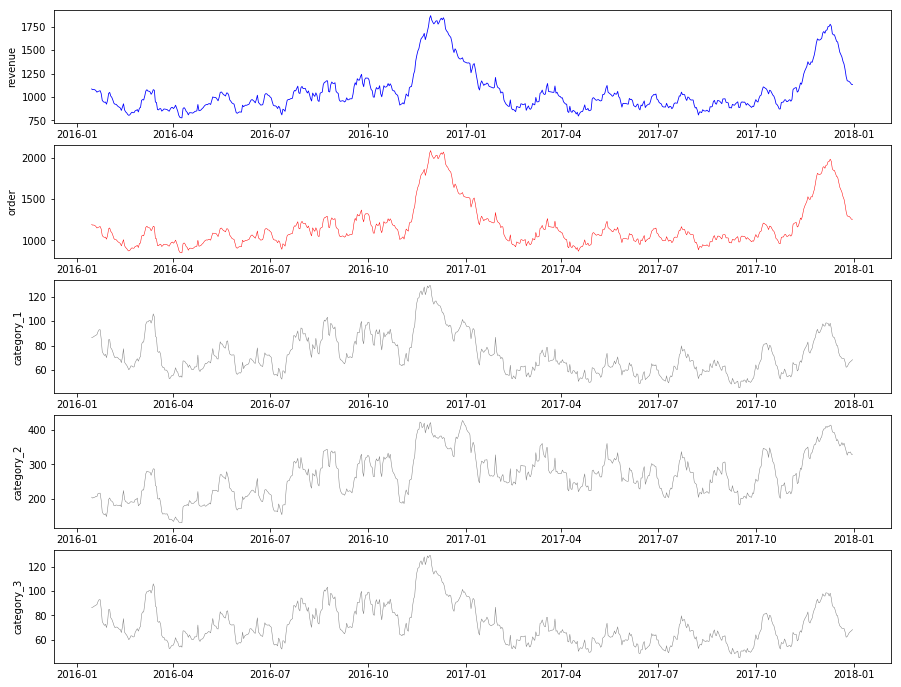

In [104]:
df_online_agg_ma = df_online_agg.rolling(15).mean()

plt.figure(figsize=(15, 12))

ax1 = plt.subplot(5, 1, 1)
ax1.set_ylabel('revenue')
ax1.plot(df_online_agg_ma.index, df_online_agg_ma.daily_visitor, color='b', linewidth=0.8)

ax2 = plt.subplot(5, 1, 2)
ax2.set_ylabel('order')
ax2.plot(df_online_agg_ma.index, df_online_agg_ma.daily_session, color='r', linewidth=0.5)

ax3 = plt.subplot(5, 1, 3)
ax3.set_ylabel('category_1')
ax3.plot(df_online_agg_ma.index, df_online_agg_ma.category_1, color='gray', linewidth=0.5)

ax4 = plt.subplot(5, 1, 4)
ax4.set_ylabel('category_2')
ax4.plot(df_online_agg_ma.index, df_online_agg_ma.category_2, color='gray', linewidth=0.5)

ax5 = plt.subplot(5, 1, 5)
ax5.set_ylabel('category_3')
ax5.plot(df_online_agg_ma.index, df_online_agg_ma.category_3, color='gray', linewidth=0.5)

In [119]:
df_online_agg.describe()

,daily_visitor,daily_session,category_1,category_2,category_3
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,1056.101231,1163.415869,72.454172,266.607387,72.454172
std,413.630784,460.529218,44.525954,180.068816,44.525954
min,463.000000,498.000000,17.000000,70.000000,17.000000
25%,749.000000,826.500000,41.500000,141.500000,41.500000
50%,937.000000,1028.000000,58.000000,197.000000,58.000000
75%,1244.000000,1366.500000,89.000000,338.000000,89.000000
max,2952.000000,3324.000000,281.000000,1144.000000,281.000000


In [107]:
df_online_agg.corr()

,daily_visitor,daily_session,category_1,category_2,category_3
daily_visitor,1.000000,0.999093,0.870098,0.869929,0.870098
daily_session,0.999093,1.000000,0.861843,0.860694,0.861843
category_1,0.870098,0.861843,1.000000,0.898780,1.000000
category_2,0.869929,0.860694,0.898780,1.000000,0.898780
category_3,0.870098,0.861843,1.000000,0.898780,1.000000


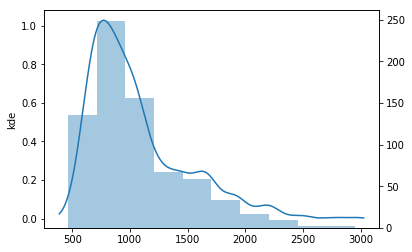

In [186]:
plot_density(df_online_agg['daily_visitor'], width = 75)

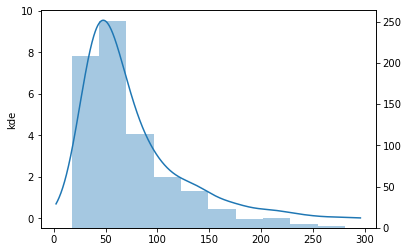

In [185]:
plot_density(df_online_agg.category_1, width = 15)

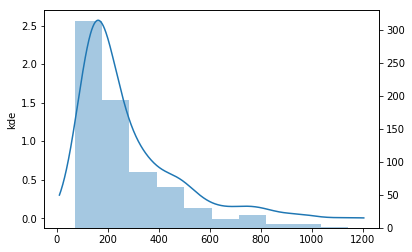

In [183]:
plot_density(df_online_agg.category_2, width=60)

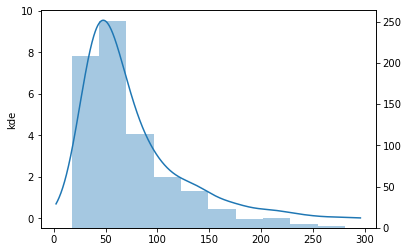

In [184]:
plot_density(df_online_agg.category_3, width=15)

#### Seasonality of Resposne Variable

In [192]:
sql = "SELECT LEFT(dt, 10) AS day"
for i in range(1, 11):
    sql += ",SUM(event2=%i) AS event2_%i"%(i, i)
sql += " FROM Online GROUP BY day ORDER BY day;"

In [193]:
df_event2_agg = pd.read_sql_query(sql.replace('\n', " ").replace("\t", " "), engine)
df_event2_agg.day = [datetime.strptime(dt, "%Y-%m-%d") for dt in df_event2_agg.day.values]
df_event2_agg.set_index("day", inplace=True)

df_event2_agg.head()

,event2_1,event2_2,event2_3,event2_4,event2_5,event2_6,event2_7,event2_8,event2_9,event2_10
day,,,,,,,,,,
2016-01-01,85.0,14.0,139.0,84.0,47.0,61.0,476.0,172.0,38.0,12.0
2016-01-02,55.0,6.0,142.0,84.0,53.0,71.0,454.0,190.0,42.0,21.0
2016-01-03,95.0,28.0,173.0,178.0,53.0,56.0,694.0,336.0,122.0,31.0
2016-01-04,80.0,10.0,179.0,164.0,60.0,52.0,641.0,228.0,113.0,18.0
2016-01-05,98.0,13.0,158.0,205.0,66.0,44.0,682.0,282.0,124.0,17.0


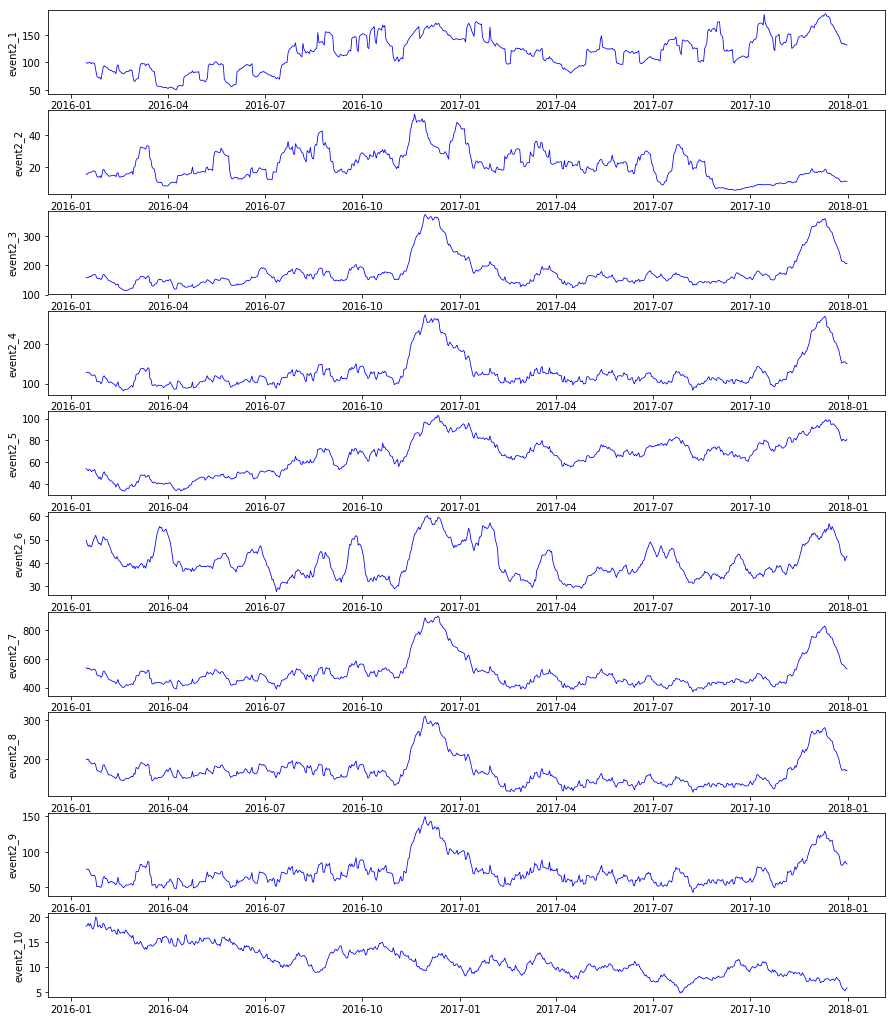

In [200]:
df_event2_agg_ma = df_event2_agg.rolling(15).mean()

plt.figure(figsize=(15, 20))

for i in range(1, 11):
    col_name = df_event2_agg_ma.columns[i - 1]
    ax1 = plt.subplot(11, 1, i)
    ax1.set_ylabel(col_name)
    ax1.plot(df_event2_agg_ma.index, df_event2_agg_ma[col_name], color='b', linewidth=0.8)

In [201]:
df_event2_agg.corr()

,event2_1,event2_2,event2_3,event2_4,event2_5,event2_6,event2_7,event2_8,event2_9,event2_10
event2_1,1.000000,0.347206,0.491952,0.548233,0.715336,0.322077,0.541405,0.516091,0.540829,-0.043527
event2_2,0.347206,1.000000,0.552707,0.663221,0.448091,0.353929,0.621428,0.642713,0.673826,0.029580
event2_3,0.491952,0.552707,1.000000,0.925580,0.712293,0.648530,0.938340,0.886412,0.851917,0.018254
event2_4,0.548233,0.663221,0.925580,1.000000,0.700400,0.565453,0.953226,0.931901,0.943787,0.059378
event2_5,0.715336,0.448091,0.712293,0.700400,1.000000,0.479389,0.701756,0.607607,0.624180,-0.134277
event2_6,0.322077,0.353929,0.648530,0.565453,0.479389,1.000000,0.645075,0.613722,0.529572,0.189257
event2_7,0.541405,0.621428,0.938340,0.953226,0.701756,0.645075,1.000000,0.938012,0.901864,0.153354
event2_8,0.516091,0.642713,0.886412,0.931901,0.607607,0.613722,0.938012,1.000000,0.913934,0.192500
event2_9,0.540829,0.673826,0.851917,0.943787,0.624180,0.529572,0.901864,0.913934,1.000000,0.108074
event2_10,-0.043527,0.029580,0.018254,0.059378,-0.134277,0.189257,0.153354,0.192500,0.108074,1.000000
